### Outline:

Some EDA

Data Preprocessing: Column Transformer

Model Building: Pipeline

Model selection: Grid Search CV

Save model: Joblib

Make predictions on an unseen data point

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [2]:
df = pd.read_csv('Mydata.csv')
df.head()

,S.NO.,first_name,last_name,email,gender,First Year Marks,Second Year Marks,Third Year Marks,Course,Language,Country,Parental Education
0,1,Anatola,Mathewson,amathewson0@1und1.de,Genderfluid,94,61,55,Product Management,Somali,Russia,False
1,2,Fanni,Adran,fadran1@xinhuanet.com,Female,76,87,92,Human Resources,Macedonian,Russia,False
2,3,Dick,Claisse,dclaisse2@php.net,Male,70,100,77,Human Resources,Māori,Russia,False
3,4,Yoshi,Lowfill,ylowfill3@usda.gov,Female,73,98,57,Sales,Spanish,Russia,False
4,5,Romy,Reisenberg,rreisenberg4@mit.edu,Female,86,58,91,Engineering,Tetum,Russia,False


In [3]:
df.shape

(1000, 12)

In [4]:
df.isna().sum()

S.NO.                 0
first_name            0
last_name             0
email                 0
gender                0
First Year Marks      0
Second Year Marks     0
Third Year Marks      0
Course                0
Language              0
Country               0
Parental Education    0
dtype: int64

In [5]:
scores = df.columns[df.columns.str.contains('Marks')].tolist()
scores

['First Year Marks', 'Second Year Marks', 'Third Year Marks']

##### EDA:

histograms:

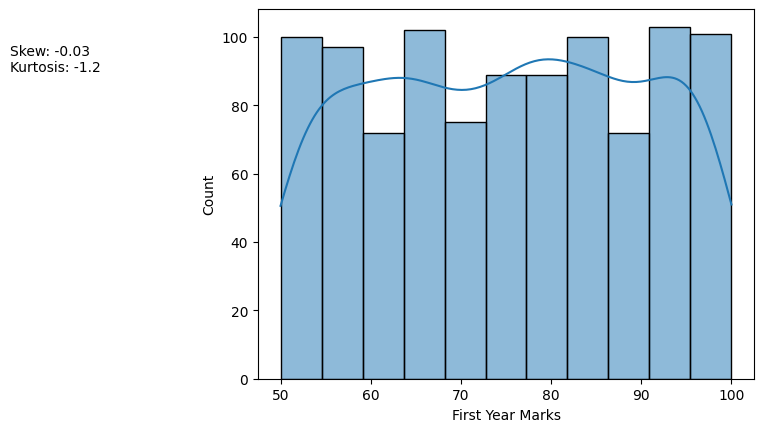

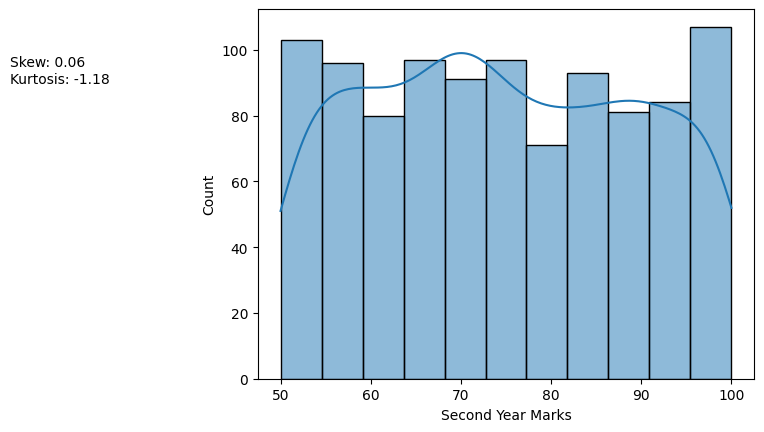

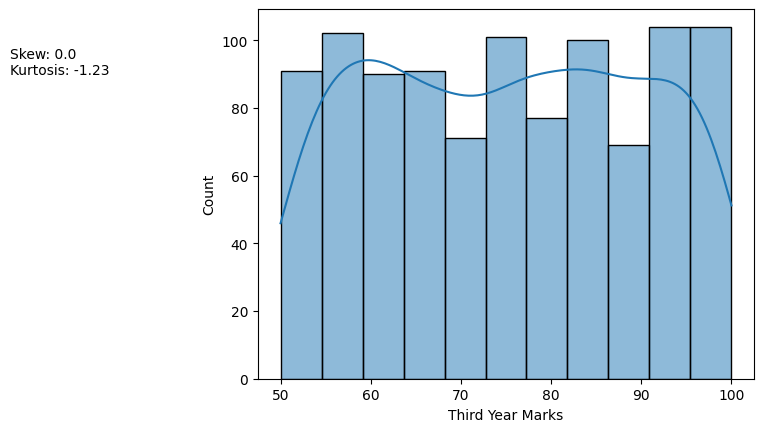

In [6]:
for Marks in scores:
    sns.histplot(df[Marks], element='bars', kde=True)
    plt.text(x=20, y=90, s=f"Skew: {round(df[Marks].skew(),2)}\nKurtosis: {round(df[Marks].kurt(),2)}")
    plt.show()

In [7]:
df.describe()

,S.NO.,First Year Marks,Second Year Marks,Third Year Marks
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,75.169000,74.691000,75.175000
std,288.819436,14.818638,14.780595,14.743397
min,1.000000,50.000000,50.000000,50.000000
25%,250.750000,62.000000,62.000000,62.000000
50%,500.500000,76.000000,74.000000,76.000000
75%,750.250000,88.000000,88.000000,88.000000
max,1000.000000,100.000000,100.000000,100.000000


pairplot:

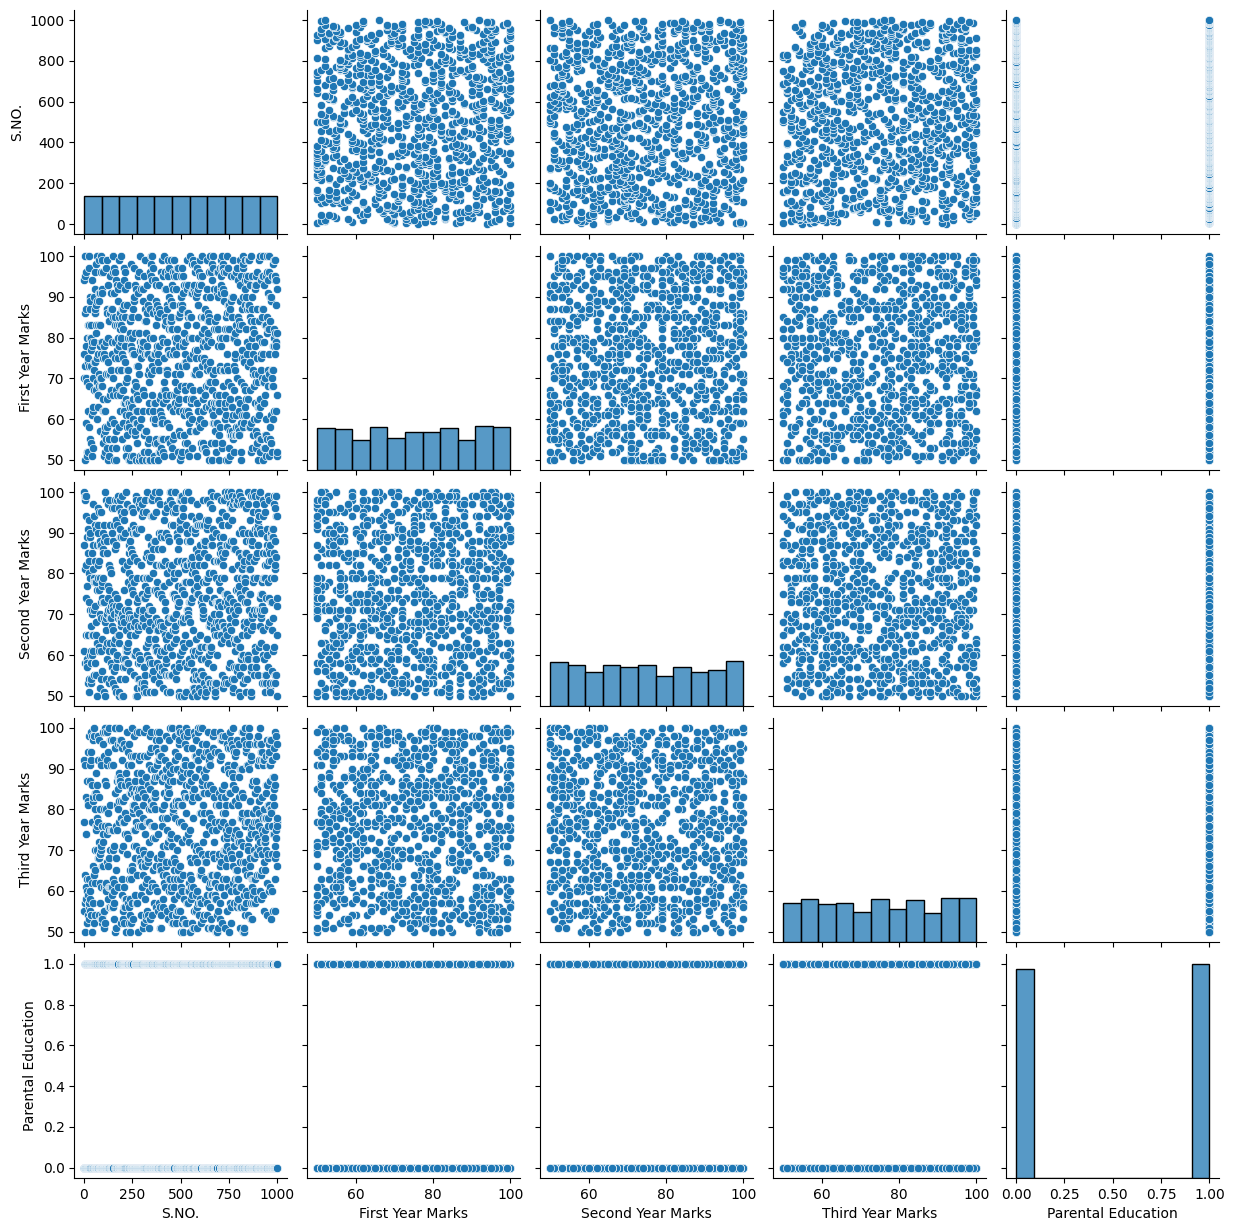

In [8]:
sns.pairplot(data=df)

scores vs lunch type:

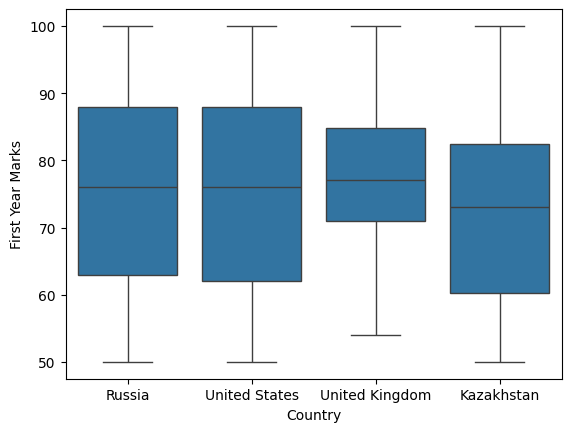

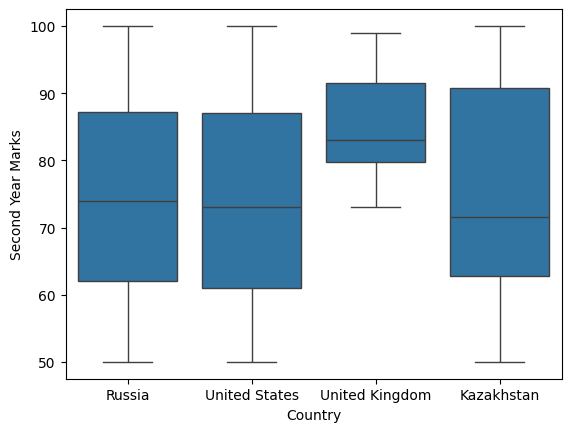

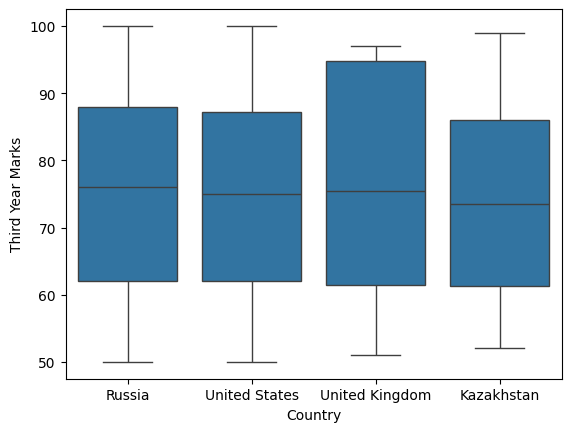

In [9]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Country'])
    plt.show()

scores vs race/ ethnicity group:

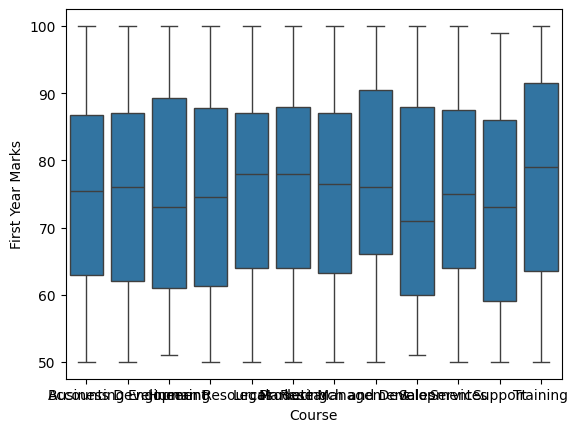

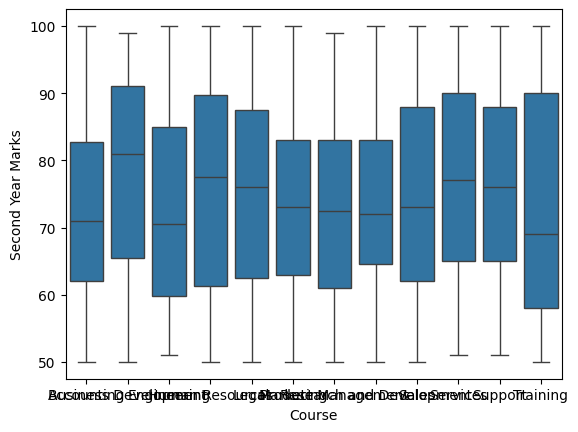

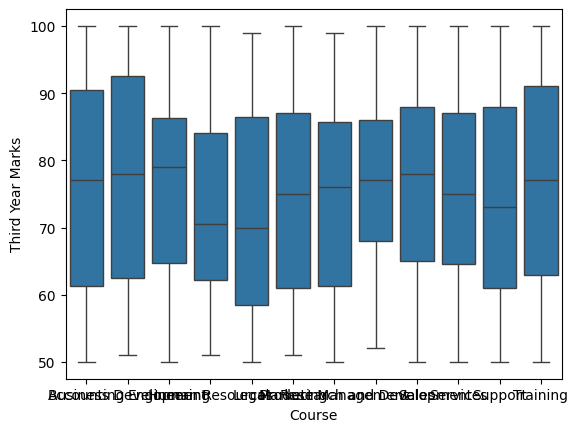

In [10]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Course'], order=sorted(df['Course'].unique()))
    plt.show()

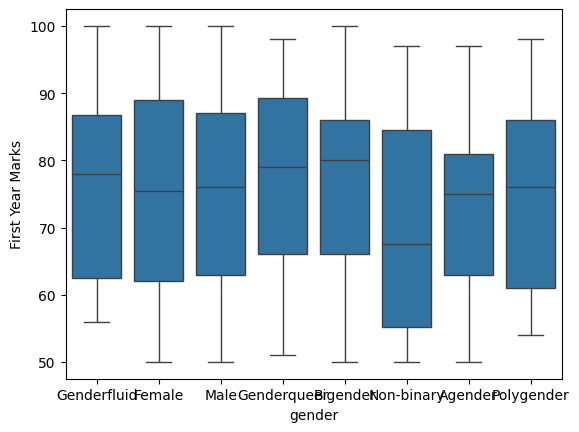

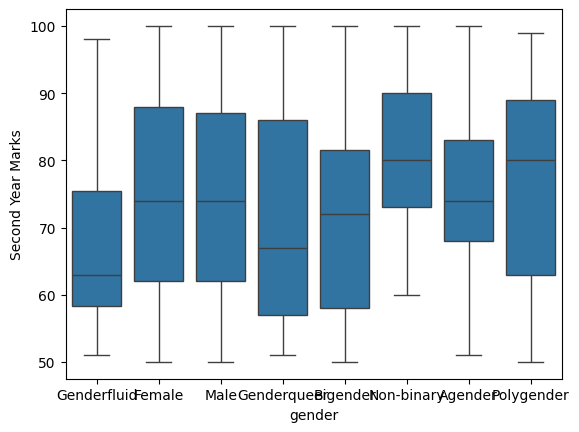

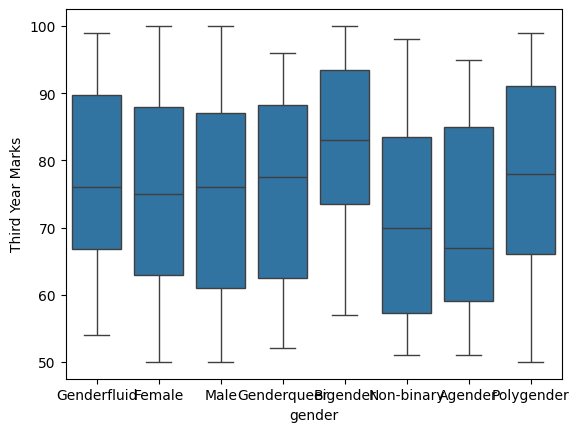

In [11]:
for score in scores:
    sns.boxplot(y=df[score], x=df['gender'])
    plt.show()

scores vs whether completed the test prep course:

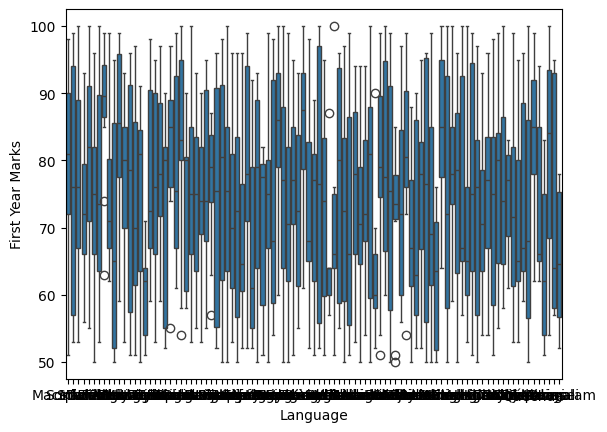

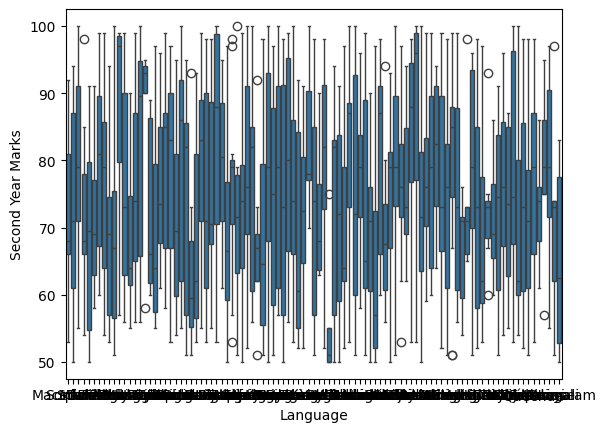

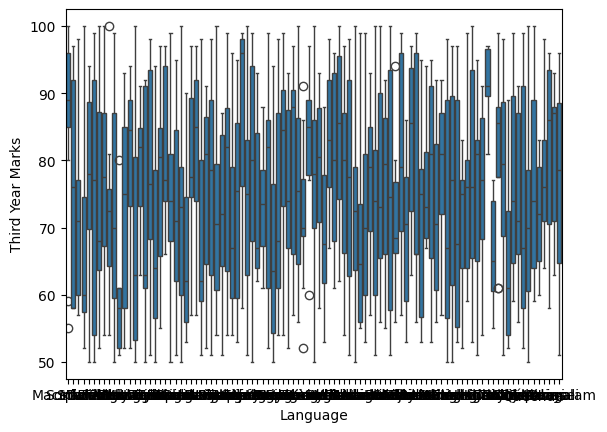

In [12]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Language'])
    plt.show()

scores vs parental education level:

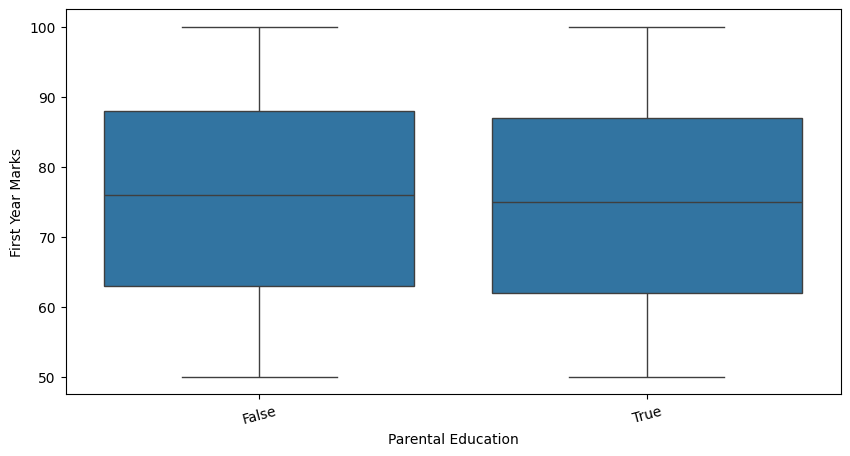

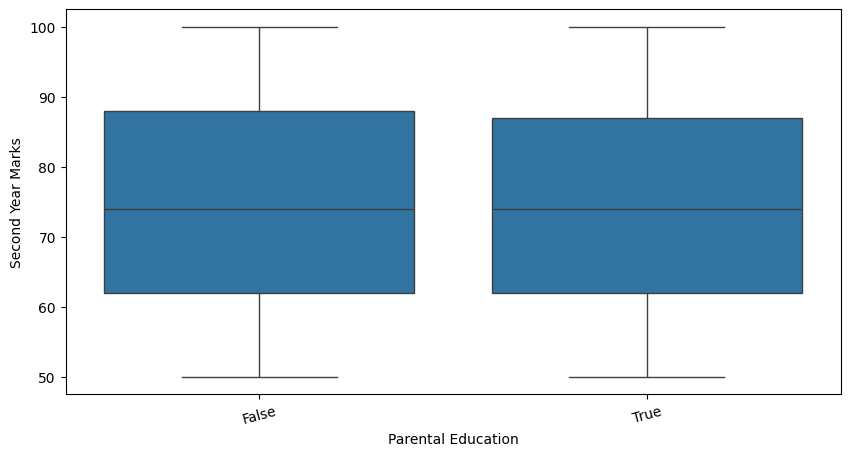

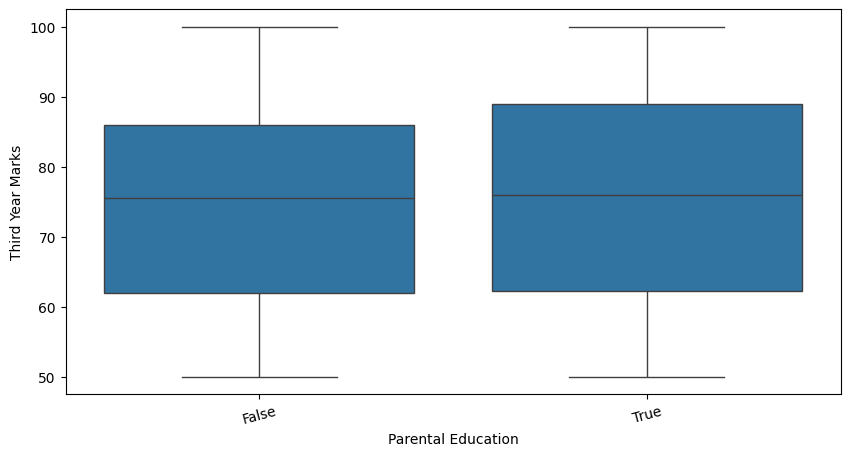

In [13]:
for score in scores:
    plt.figure(figsize=(10,5))
    sns.boxplot(y=df[score], x=df['Parental Education'])
    plt.xticks(rotation=15)
    plt.show()

In [14]:
X, y = df.drop('Third Year Marks', axis=1), df['Third Year Marks']

In [15]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

['first_name', 'last_name', 'email', 'gender', 'Course', 'Language', 'Country']

In [16]:
ct = ColumnTransformer([
    ('num', StandardScaler(), ['First Year Marks', 'Second Year Marks']),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [17]:
ct.fit_transform(X).shape

(1000, 3059)

In [18]:
pipe = Pipeline([
    ('trf', ct),
    ('model', LGBMRegressor(random_state=0))
])

In [19]:
params = {
    'model__n_estimators':[100,130,150,170,190],
    'model__boosting_type': ['dart', 'gbdt', 'goss']
}

In [20]:
gs = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [21]:
gs.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 24
[LightGBM] [Info] Start training from score 75.175000


GridSearchCV(estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['First '
                                                                          'Year '
                                                                          'Marks',
                                                                          'Second '
                                                                          'Year '
                                                                          'Marks']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['first_name',
                                                                          'last_name',
                                                                          'email',
                                                                          'gender',
                                                                          'Course',
                                                                          'Language',
                                                                          'Country'])])),
                                       ('model',
                                        LGBMRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__boosting_type': ['dart', 'gbdt', 'goss'],
                         'model__n_estimators': [100, 130, 150, 170, 190]},
             scoring='neg_root_mean_squared_error')

In [22]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.575527,0.083579,0.099908,0.004982,gbdt,100,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.347931,-15.723698,-16.755173,-15.474949,-14.412517,-15.742854,0.804095,1
10,0.927653,0.168986,0.102570,0.006539,goss,100,"{'model__boosting_type': 'goss', 'model__n_est...",-18.836374,-15.579980,-16.141257,-14.674994,-14.160208,-15.878563,1.631449,2
4,2.875683,0.257998,0.098135,0.003123,dart,190,"{'model__boosting_type': 'dart', 'model__n_est...",-17.468416,-15.574965,-16.651322,-14.886281,-14.844248,-15.885046,1.026760,3
11,1.612871,0.320250,0.118157,0.018859,goss,130,"{'model__boosting_type': 'goss', 'model__n_est...",-18.141202,-15.586004,-16.331013,-15.208363,-14.251681,-15.903653,1.304040,4
12,2.204037,0.171687,0.099781,0.001471,goss,150,"{'model__boosting_type': 'goss', 'model__n_est...",-18.552721,-15.409238,-16.458253,-15.023256,-14.103017,-15.909297,1.522289,5
6,1.732460,0.109118,0.098081,0.005491,gbdt,130,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.612174,-15.832561,-17.088707,-15.710948,-14.525319,-15.953942,0.875866,6
7,1.698198,0.019970,0.096657,0.009105,gbdt,150,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.604092,-15.905823,-17.170171,-15.690409,-14.550451,-15.984189,0.887568,7
8,1.777744,0.042931,0.098673,0.005221,gbdt,170,"{'model__boosting_type': 'gbdt', 'model__n_est...",-16.684603,-15.957999,-17.254586,-15.801728,-14.591794,-16.058142,0.899987,8
13,1.948593,0.198271,0.125142,0.025902,goss,170,"{'model__boosting_type': 'goss', 'model__n_est...",-19.412811,-15.309155,-16.663847,-15.073329,-14.073586,-16.106545,1.848149,9
2,2.241178,0.140852,0.101354,0.009545,dart,150,"{'model__boosting_type': 'dart', 'model__n_est...",-17.900544,-15.622977,-16.705699,-14.972394,-15.477313,-16.135785,1.047780,10


In [23]:
gs.best_params_

{'model__boosting_type': 'gbdt', 'model__n_estimators': 100}

In [24]:
gs.best_score_

-15.742853714776519

In [25]:
gs.best_estimator_

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['First Year Marks',
                                                   'Second Year Marks']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['first_name', 'last_name',
                                                   'email', 'gender', 'Course',
                                                   'Language', 'Country'])])),
                ('model', LGBMRegressor(random_state=0))])

In [26]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

##### importing the model:

In [27]:
mdl = joblib.load('model.joblib')

##### Making predictions on a new data point NOT seen by the model

In [28]:
q = pd.DataFrame([[3 , 'piyush' , 'jangra' , 'piyush@php.net' , 'Male' , 100 , 99 , 'Engineering' , 'Russian' , 'India' , True]],
             columns=X.columns)
q

,S.NO.,first_name,last_name,email,gender,First Year Marks,Second Year Marks,Course,Language,Country,Parental Education
0,3,piyush,jangra,piyush@php.net,Male,100,99,Engineering,Russian,India,True


In [29]:
mdl.predict(q)

array([67.34583163])